Natural Language Processing with Disaster Tweets

An Yu

In [1]:
import numpy as np
import seaborn as sns
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics #Evaluate model performance
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import re #regular expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from spellchecker import SpellChecker
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import warnings
warnings.filterwarnings('ignore')

#Load test and train data

data_test = pd.read_csv(".../nlp-getting-started/test.csv")

data_train = pd.read_csv(".../nlp-getting-started/train.csv")


print("Train data\n", data_train.isna().sum(),"\n\nTest data\n",data_test.isna().sum())
data_train.head()

Train data
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64 

Test data
 id             0
keyword       26
location    1105
text           0
dtype: int64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


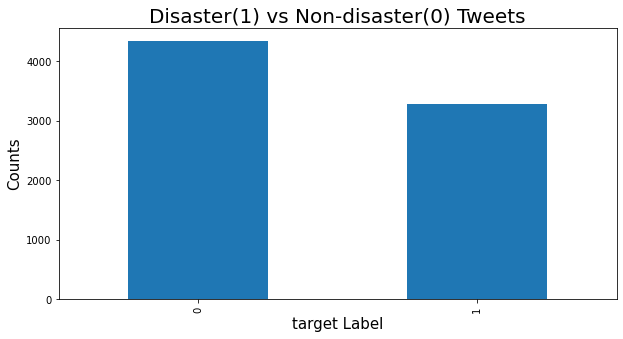

In [3]:
#Explore ytrain_target
fig = plt.figure(figsize=(10,5))
data_train.groupby('target').text.count().plot.bar()
plt.xlabel("target Label",fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.title("Disaster(1) vs Non-disaster(0) Tweets", fontsize=20)
plt.grid(False)
plt.show()


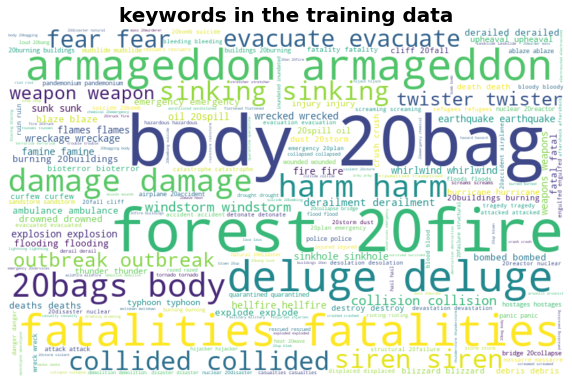

In [4]:
# Getting all keywords in data_train
train_keywords = " ".join([keyword for keyword in data_train["keyword"].dropna()])
# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=100,
                      background_color ='white',
                      random_state=24).generate(train_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("keywords in the training data", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()


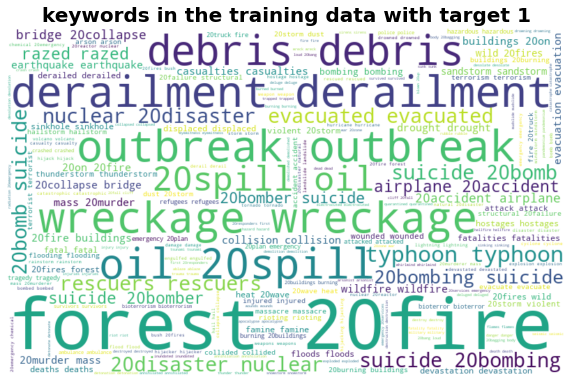

In [5]:
# all keywords from data_train tweets associated to a disaster 
data_train_disaster_keywords = " ".join([keyword for keyword in data_train[data_train["target"]==1]["keyword"].dropna()])
# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=100,
                      background_color ='white',
                      random_state=24).generate(data_train_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("keywords in the training data with target 1", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
#Cleaning text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')  # re.compile  to Regular Expression
    return url.sub(r'', text)

def remove_hashtag(text):
    hashtag = re.compile(r'#')
    return hashtag.sub(r'', text)

def remove_at(text):
    at = re.compile(r'@')
    return at.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punc(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

#create a dictionary for abbreviations
abbreviations = {
    "$": " dollar ",
    "€": " euro ",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3": "anytime anywhere anyplace",
    "aamof": "as a matter of fact",
    "acct": "account",
    "adih": "another day in hell",
    "afaic": "as far as i am concerned",
    "afaict": "as far as i can tell",
    "afaik": "as far as i know",
    "afair": "as far as i remember",
    "afk": "away from keyboard",
    "app": "application",
    "approx": "approximately",
    "apps": "applications",
    "asap": "as soon as possible",
    "asl": "age, sex, location",
    "atk": "at the keyboard",
    "ave.": "avenue",
    "aymm": "are you my mother",
    "ayor": "at your own risk",
    "b&b": "bed and breakfast",
    "b+b": "bed and breakfast",
    "b.c": "before christ",
    "b2b": "business to business",
    "b2c": "business to customer",
    "b4": "before",
    "b4n": "bye for now",
    "b@u": "back at you",
    "bae": "before anyone else",
    "bak": "back at keyboard",
    "bbbg": "bye bye be good",
    "bbc": "british broadcasting corporation",
    "bbias": "be back in a second",
    "bbl": "be back later",
    "bbs": "be back soon",
    "be4": "before",
    "bfn": "bye for now",
    "blvd": "boulevard",
    "bout": "about",
    "brb": "be right back",
    "bros": "brothers",
    "brt": "be right there",
    "bsaaw": "big smile and a wink",
    "btw": "by the way",
    "bwl": "bursting with laughter",
    "c/o": "care of",
    "cet": "central european time",
    "cf": "compare",
    "cia": "central intelligence agency",
    "csl": "can not stop laughing",
    "cu": "see you",
    "cul8r": "see you later",
    "cv": "curriculum vitae",
    "cwot": "complete waste of time",
    "cya": "see you",
    "cyt": "see you tomorrow",
    "dae": "does anyone else",
    "dbmib": "do not bother me i am busy",
    "diy": "do it yourself",
    "dm": "direct message",
    "dwh": "during work hours",
    "e123": "easy as one two three",
    "eet": "eastern european time",
    "eg": "example",
    "embm": "early morning business meeting",
    "encl": "enclosed",
    "encl.": "enclosed",
    "etc": "and so on",
    "faq": "frequently asked questions",
    "fawc": "for anyone who cares",
    "fb": "facebook",
    "fc": "fingers crossed",
    "fig": "figure",
    "fimh": "forever in my heart",
    "ft.": "feet",
    "ft": "featuring",
    "ftl": "for the loss",
    "ftw": "for the win",
    "fwiw": "for what it is worth",
    "fyi": "for your information",
    "g9": "genius",
    "gahoy": "get a hold of yourself",
    "gal": "get a life",
    "gcse": "general certificate of secondary education",
    "gfn": "gone for now",
    "gg": "good game",
    "gl": "good luck",
    "glhf": "good luck have fun",
    "gmt": "greenwich mean time",
    "gmta": "great minds think alike",
    "gn": "good night",
    "g.o.a.t": "greatest of all time",
    "goat": "greatest of all time",
    "goi": "get over it",
    "gps": "global positioning system",
    "gr8": "great",
    "gratz": "congratulations",
    "gyal": "girl",
    "h&c": "hot and cold",
    "hp": "horsepower",
    "hr": "hour",
    "hrh": "his royal highness",
    "ht": "height",
    "ibrb": "i will be right back",
    "ic": "i see",
    "icq": "i seek you",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "idgadf": "i do not give a damn fuck",
    "idgaf": "i do not give a fuck",
    "idk": "i do not know",
    "ie": "that is",
    "i.e": "that is",
    "ifyp": "i feel your pain",
    "IG": "instagram",
    "iirc": "if i remember correctly",
    "ilu": "i love you",
    "ily": "i love you",
    "imho": "in my humble opinion",
    "imo": "in my opinion",
    "imu": "i miss you",
    "iow": "in other words",
    "irl": "in real life",
    "j4f": "just for fun",
    "jic": "just in case",
    "jk": "just kidding",
    "jsyk": "just so you know",
    "l8r": "later",
    "lb": "pound",
    "lbs": "pounds",
    "ldr": "long distance relationship",
    "lmao": "laugh my ass off",
    "lmfao": "laugh my fucking ass off",
    "lol": "laughing out loud",
    "ltd": "limited",
    "ltns": "long time no see",
    "m8": "mate",
    "mf": "motherfucker",
    "mfs": "motherfuckers",
    "mfw": "my face when",
    "mofo": "motherfucker",
    "mph": "miles per hour",
    "mr": "mister",
    "mrw": "my reaction when",
    "ms": "miss",
    "mte": "my thoughts exactly",
    "nagi": "not a good idea",
    "nbc": "national broadcasting company",
    "nbd": "not big deal",
    "nfs": "not for sale",
    "ngl": "not going to lie",
    "nhs": "national health service",
    "nrn": "no reply necessary",
    "nsfl": "not safe for life",
    "nsfw": "not safe for work",
    "nth": "nice to have",
    "nvr": "never",
    "nyc": "new york city",
    "oc": "original content",
    "og": "original",
    "ohp": "overhead projector",
    "oic": "oh i see",
    "omdb": "over my dead body",
    "omg": "oh my god",
    "omw": "on my way",
    "p.a": "per annum",
    "p.m": "after midday",
    "pm": "prime minister",
    "poc": "people of color",
    "pov": "point of view",
    "pp": "pages",
    "ppl": "people",
    "prw": "parents are watching",
    "ps": "postscript",
    "pt": "point",
    "ptb": "please text back",
    "pto": "please turn over",
    "qpsa": "what happens",  # "que pasa",
    "ratchet": "rude",
    "rbtl": "read between the lines",
    "rlrt": "real life retweet",
    "rofl": "rolling on the floor laughing",
    "roflol": "rolling on the floor laughing out loud",
    "rotflmao": "rolling on the floor laughing my ass off",
    "rt": "retweet",
    "ruok": "are you ok",
    "sfw": "safe for work",
    "sk8": "skate",
    "smh": "shake my head",
    "sq": "square",
    "srsly": "seriously",
    "ssdd": "same stuff different day",
    "tbh": "to be honest",
    "tbs": "tablespooful",
    "tbsp": "tablespooful",
    "tfw": "that feeling when",
    "thks": "thank you",
    "tho": "though",
    "thx": "thank you",
    "tia": "thanks in advance",
    "til": "today i learned",
    "tl;dr": "too long i did not read",
    "tldr": "too long i did not read",
    "tmb": "tweet me back",
    "tntl": "trying not to laugh",
    "ttyl": "talk to you later",
    "u": "you",
    "u2": "you too",
    "u4e": "yours for ever",
    "utc": "coordinated universal time",
    "w/": "with",
    "w/o": "without",
    "w8": "wait",
    "wassup": "what is up",
    "wb": "welcome back",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wtpa": "where the party at",
    "wuf": "where are you from",
    "wuzup": "what is up",
    "wywh": "wish you were here",
    "yd": "yard",
    "ygtr": "you got that right",
    "ynk": "you never know",
    "zzz": "sleeping bored and tired"
}

#fuction to convert abbreviations
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)  
    return text


#Check Spelling
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#Remove special word U_hat
def other_word(text):
    other = re.compile(r'amp|Û') 
    return other.sub(r'', text)

In [7]:
data_train['text'] = data_train['text'].str.lower()
data_train['text'] = data_train['text'].apply(lambda text: remove_url(text))
data_train['text'] = data_train['text'].apply(lambda text: remove_hashtag(text))
data_train['text'] = data_train['text'].apply(lambda text: remove_at(text))
data_train['text'] = data_train['text'].apply(lambda text: remove_punc(text))
data_train['text'] = data_train['text'].apply(lambda text: remove_emoji(text))
data_train['text'] = data_train['text'].apply(lambda text: convert_abbrev_in_text(text))
#data_train['text'] = data_train['text'].apply(lambda text: correct_spellings(text))
data_train['text'] = data_train['text'].apply(lambda text: other_word(text))

data_test['text'] = data_test['text'].str.lower()
data_test['text'] = data_test['text'].apply(lambda text: remove_url(text))
data_test['text'] = data_test['text'].apply(lambda text: remove_hashtag(text))
data_test['text'] = data_test['text'].apply(lambda text: remove_at(text))
data_test['text'] = data_test['text'].apply(lambda text: remove_punc(text))
data_test['text'] = data_test['text'].apply(lambda text: remove_emoji(text))
data_test['text'] = data_test['text'].apply(lambda text: convert_abbrev_in_text(text))
#data_test['text'] = data_test['text'].apply(lambda text: correct_spellings(text))
data_test['text'] = data_test['text'].apply(lambda text: other_word(text))


In [8]:


X_train, X_test, y_train, y_test = train_test_split(data_train['text'],data_train['target'].values,test_size = 0.3,random_state = 53)

In [9]:
# count vectorizer transformation
count_vectorizer = CountVectorizer(stop_words = 'english')
count_vectorizer.fit(X_train.values.tolist() + X_test.values.tolist()+data_test['text'].tolist())
train_count_vect = count_vectorizer.transform(X_train.values)
print(count_vectorizer.get_feature_names()[:10])
test_count_vect = count_vectorizer.transform(X_test.values)

['00', '0011', '001116', '0025', '005225', '010156', '010217', '010242', '0104', '010401']


In [10]:
# tfidf vectorizer transformation 
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english',max_df = 0.7)
tfidf_vectorizer.fit(X_train.values.tolist() + X_test.values.tolist()+data_test['text'].tolist())
train_tfidf_vect = tfidf_vectorizer.transform(X_train.values)
print(tfidf_vectorizer.get_feature_names()[:10])
test_tfidf_vect = tfidf_vectorizer.transform(X_test.values)
print(len(tfidf_vectorizer.get_feature_names()))
print(train_tfidf_vect)

['00', '0011', '001116', '0025', '005225', '010156', '010217', '010242', '0104', '010401']
22027
  (0, 13028)	0.4416115622904392
  (0, 10594)	0.507879143700775
  (0, 9766)	0.22908834191597416
  (0, 6165)	0.507879143700775
  (0, 5835)	0.4864311980507853
  (1, 21806)	0.5243900680926112
  (1, 19273)	0.42652989032913774
  (1, 18262)	0.41081761463979827
  (1, 15100)	0.3294335964180435
  (1, 15015)	0.2777220625606061
  (1, 9983)	0.3242980355989022
  (1, 2068)	0.28894799232414836
  (2, 20132)	0.3873995112235327
  (2, 18289)	0.4044809066908675
  (2, 15056)	0.3873995112235327
  (2, 14151)	0.4044809066908675
  (2, 11386)	0.3517046276380394
  (2, 8049)	0.32562580280916725
  (2, 7270)	0.25914015985647343
  (2, 2170)	0.2752302647694076
  (3, 21517)	0.29354903281971395
  (3, 20384)	0.39106767680689775
  (3, 18608)	0.44159685812299804
  (3, 16321)	0.3099538128309038
  (3, 10972)	0.2867226561016365
  :	:
  (5324, 10231)	0.27389459939374905
  (5324, 6810)	0.25157336210763953
  (5324, 3622)	0.2548028722

In [11]:
from sklearn.model_selection import cross_val_score, KFold 
kf = KFold(n_splits=4)
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

 "Gaussian_naive_bayes":GaussianNB()
    "linear_discriminant_analysis":LDA(),
    "quadratic_discriminant_analysis":QDA(),
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "random_forest": RandomForestClassifier()
    
current vectors
vectors = {
    "count_vectorizer": train_count_vect,
    "tfidf_vectorizer": train_tfidf_vect
    test_count_vect
    test_tfidf_vect
}

GaussianNB() test accuracy is:  0.6313485113835376

Processing time is(seconds):  10.398879051208496

GaussianNB() Statistics of is:
       GaussianNB()
count      4.000000
mean       0.628637
std        0.015692
min        0.616366
25%        0.621083
50%        0.623265
75%        0.630818
max        0.651652


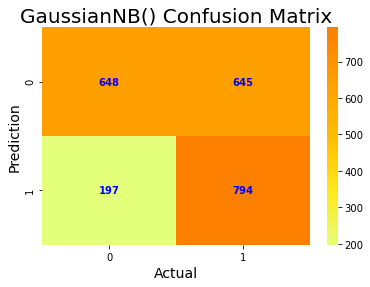

KNeighborsClassifier() test accuracy is:  0.6751313485113836

Processing time is(seconds):  13.5228590965271

KNeighborsClassifier() Statistics of is:
       KNeighborsClassifier()
count                4.000000
mean                 0.665414
std                  0.016360
min                  0.641892
25%                  0.661599
50%                  0.670168
75%                  0.673983
max                  0.679429


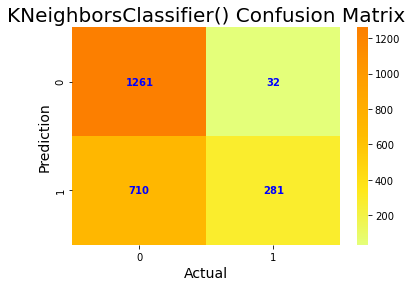

LogisticRegression() test accuracy is:  0.7915936952714536

Processing time is(seconds):  14.084414958953857

LogisticRegression() Statistics of is:
       LogisticRegression()
count              4.000000
mean               0.793396
std                0.005451
min                0.785446
25%                0.792082
50%                0.795420
75%                0.796734
max                0.797297


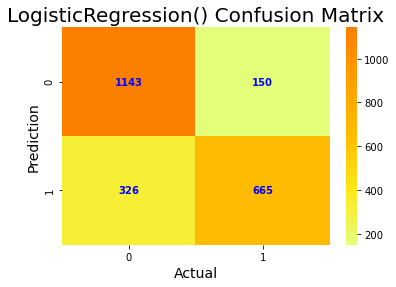

MultinomialNB() test accuracy is:  0.7876532399299475

Processing time is(seconds):  4.821866989135742

MultinomialNB() Statistics of is:
       MultinomialNB()
count         4.000000
mean          0.792458
std           0.009005
min           0.783196
25%           0.788704
50%           0.790916
75%           0.794670
max           0.804805


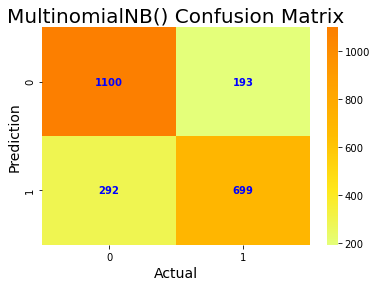

In [12]:
#Count_Vectorizer
gnb = GaussianNB()
knn = KNeighborsClassifier()
svm = SVC()
lg = LogisticRegression()
mnb = MultinomialNB()
rfc = RandomForestClassifier()

models = {gnb,knn,lg,mnb}


for clf in models:
    start = time.time()
    clf.fit(train_count_vect.toarray(),y_train)
    s_ = cross_val_score(clf, train_count_vect.toarray(),y_train, cv=kf)
    end = time.time()
    clf_time = end-start
    pred_clf = clf.predict(test_count_vect.toarray())
    
    print( str (clf)+" test accuracy is: ", metrics.accuracy_score((y_test),pred_clf))
    print("\nProcessing time is(seconds): ", clf_time)
    print("\n" +  str (clf) + " Statistics of is:")
    print(pd.DataFrame(s_, columns = [clf]).describe())
    labels=[0,1]
    cm = metrics.confusion_matrix(y_test,pred_clf)
    sns.heatmap(cm, annot = True, annot_kws={'size':10,'weight':'bold', 'color':'blue'},cmap='Wistia',fmt='d') 
    plt.title(str(clf) + ' Confusion Matrix',fontsize=20)
    plt.xlabel('Actual',fontsize=14)
    plt.ylabel('Prediction',fontsize=14)
    plt.show()
    


   





GaussianNB() test accuracy is:  0.6300350262697023

 Processing time is(seconds):  8.754220962524414

GaussianNB() confusion matrix is: [[683 610]
 [235 756]]

 Statistics of GaussianNB() is:
       GaussianNB()
count      4.000000
mean       0.624885
std        0.014015
min        0.612153
25%        0.618691
50%        0.621246
75%        0.627440
max        0.644895


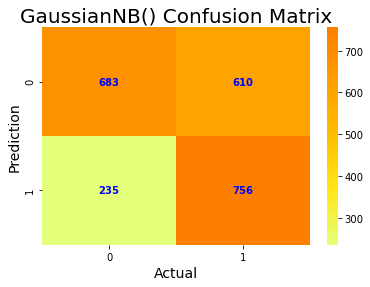


KNeighborsClassifier() test accuracy is:  0.7596322241681261

 Processing time is(seconds):  11.851536989212036

KNeighborsClassifier() confusion matrix is: [[1179  114]
 [ 435  556]]

 Statistics of KNeighborsClassifier() is:
       KNeighborsClassifier()
count                4.000000
mean                 0.760932
std                  0.009657
min                  0.749249
25%                  0.755017
50%                  0.762103
75%                  0.768018
max                  0.770270


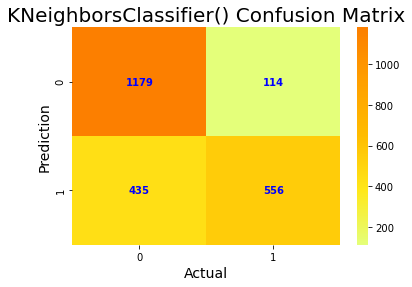


LogisticRegression() test accuracy is:  0.7841506129597198

 Processing time is(seconds):  11.250807046890259

LogisticRegression() confusion matrix is: [[1197   96]
 [ 397  594]]

 Statistics of LogisticRegression() is:
       LogisticRegression()
count              4.000000
mean               0.793770
std                0.002818
min                0.790541
25%                0.792346
50%                0.793621
75%                0.795045
max                0.797297


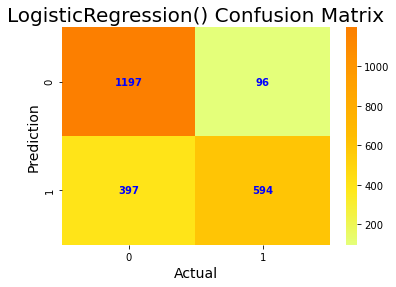


MultinomialNB() test accuracy is:  0.792031523642732

 Processing time is(seconds):  2.0091960430145264

MultinomialNB() confusion matrix is: [[1177  116]
 [ 359  632]]

 Statistics of MultinomialNB() is:
       MultinomialNB()
count         4.000000
mean          0.796396
std           0.005725
min           0.788288
25%           0.794482
50%           0.798123
75%           0.800038
max           0.801051


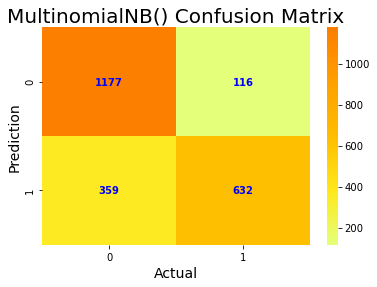

In [13]:
#Tf-Idf_vectorizer

models_ = {gnb,knn,lg,mnb}

for clf in models_:
    start = time.time()
    clf.fit(train_tfidf_vect.toarray(),y_train)
    s_ = cross_val_score(clf, train_tfidf_vect.toarray(),y_train, cv=kf)
    end = time.time()
    clf_time = end-start
    pred_clf = clf.predict(test_tfidf_vect.toarray())
    
    print("\n" + str(clf) + " test accuracy is: ", metrics.accuracy_score((y_test),pred_clf))
    print("\n Processing time is(seconds): ", clf_time)
    print("\n" + str(clf) +" confusion matrix is:",metrics.confusion_matrix(y_test,pred_clf))
    print("\n Statistics of " + str(clf) + " is:")
    print(pd.DataFrame(s_, columns = [clf]).describe())
    labels=[0,1]
    cm = metrics.confusion_matrix(y_test,pred_clf)
    sns.heatmap(cm, annot = True, annot_kws={'size':10,'weight':'bold', 'color':'blue'},cmap='Wistia',fmt='d') 
    plt.title(str(clf) + ' Confusion Matrix',fontsize=20)
    plt.xlabel('Actual',fontsize=14)
    plt.ylabel('Prediction',fontsize=14)
    plt.show()

Cleaning data in test set 

In [15]:
# count vectorizer transformation for test set (data_test)

ttest_count_vect = count_vectorizer.transform(data_test['text'].values)
#SVM has the highest accuracy but still very low, 79.4%

# tfidf vectorizer transformation 
ttest_tfidf_vect = tfidf_vectorizer.transform(data_test['text'].values)



Fit in the right model above to test vectorizer 
Overall, for both  count_vectorizer and tfidf_vectorizer, Multinomial Naive Bayes and Logistic model have better accuracy and reasonable processing time

In [16]:
#pred1 = mnb.predict(ttest_tfidf_vect.toarray())
#pred2 = lg.predict(ttest_tfidf_vect.toarray())
#pred3 = mnb.predict(ttest_count_vect.toarray())
pred3 = lg.predict(ttest_count_vect.toarray())

In [19]:
data_test['target'] = pred3
data_test['target'].astype('int')

0       1
1       1
2       1
3       0
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64

In [20]:
data_test[['id','target']].to_csv(".../nlp-getting-started/submission.csv", index = False)